<a href="https://colab.research.google.com/github/zhangou888/NN/blob/main/Full_Example_GCN_Embedding_%2B_XGBoost_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Full Example: GCN Embedding + XGBoost Classifier
## Overview
- **Dataset**: Cora (Citation network — papers are nodes, citations are edges, topics are labels).

- **Research Question**: Can we improve classification of academic papers into topics by first using GCN to extract graph-aware embeddings and then applying a powerful tabular classifier like XGBoost?

- **Why GCN + XGBoost?**

  - GCN captures structural relationships (graph context).

 - XGBoost is robust and interpretable for tabular learning.

 - Combining both leverages strengths: structure + performance.

## Benefits of This Approach
| Technique	| Purpose                                                |
|-----------|--------------------------------------------------------|
|GCN	      |Captures graph-structured data dependencies             |
|XGBoost	  |Strong tabular classifier, non-linear, interpretable    |
|Combo	    |Better performance than either alone in many graph tasks|


## Step 0: Install and require necessary libraries (for Colab)

In [2]:
# Install necessary packages (for Colab)
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cpu.html
!pip install xgboost
!pip install seaborn

# Imports
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## Step 1: Load Cora Dataset (graph of scientific papers)

In [3]:
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]  # Contains x (features), edge_index (graph), y (labels), masks


Processing...
Done!


## Step 2: Define GCN Model for Embedding Learning

In [4]:
# Define GCN Model for Embedding Learning
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels=64):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x  # Return embeddings (no softmax)

## Step 3: Train the GCN model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(dataset.num_node_features, hidden_channels=128).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(100):  # Reduce epochs to prevent OOM
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 4.1691
Epoch 50, Loss: 0.0125
Epoch 100, Loss: 0.0111
Epoch 150, Loss: 0.0089


## Step 4: Extract Node Embeddings from Trained GCN

In [6]:
model.eval()
with torch.no_grad():
    embeddings = model(data.x, data.edge_index).cpu().numpy()
    labels = data.y.cpu().numpy()

## Step 5: t-SNE Visualization

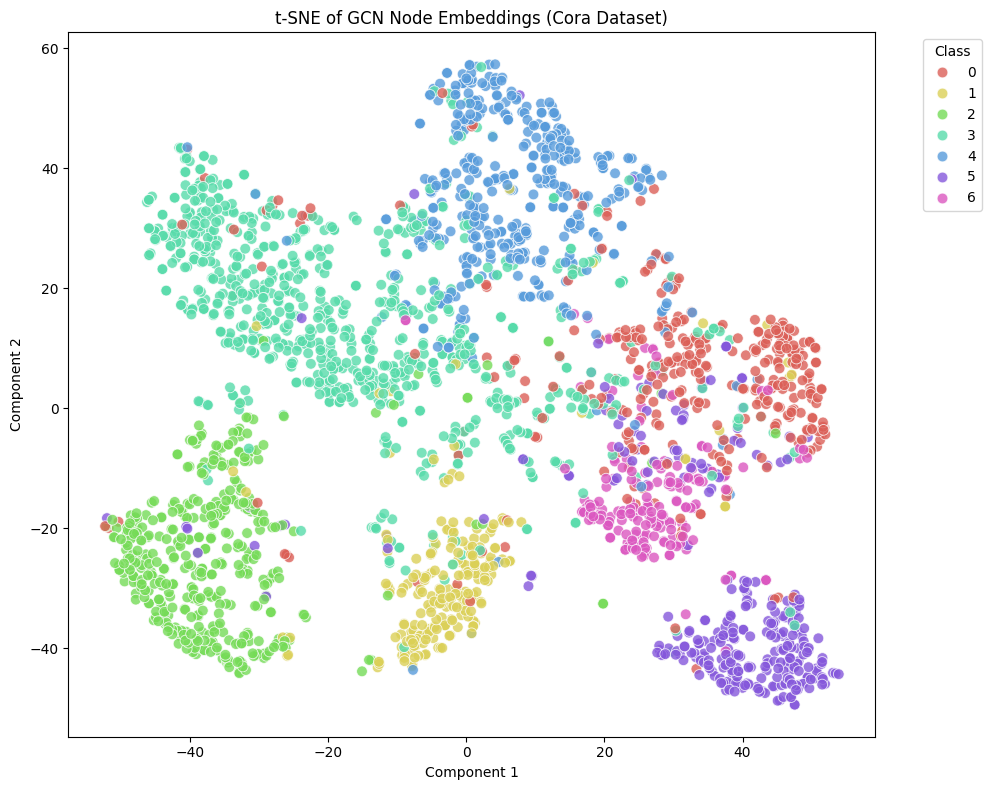

In [7]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
palette = sns.color_palette("hls", len(set(labels)))
sns.scatterplot(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    hue=labels,
    legend='full',
    palette=palette,
    s=60,
    alpha=0.8
)
plt.title("t-SNE of GCN Node Embeddings (Cora Dataset)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Step 5: Prepare Train/Test Splits using GCN Embeddings

In [8]:
X_train = embeddings[data.train_mask.cpu()]
y_train = labels[data.train_mask.cpu()]
X_test = embeddings[data.test_mask.cpu()]
y_test = labels[data.test_mask.cpu()]

## Step 6: Train XGBoost Classifier on GCN Embeddings

In [9]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

## Step 7: Evaluate Model

In [10]:
y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy on Test Set:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

XGBoost Accuracy on Test Set: 0.564

Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.86      0.36       130
           1       0.93      0.55      0.69        91
           2       0.88      0.72      0.79       144
           3       0.90      0.39      0.54       319
           4       0.88      0.58      0.70       149
           5       0.95      0.58      0.72       103
           6       0.88      0.47      0.61        64

    accuracy                           0.56      1000
   macro avg       0.81      0.59      0.63      1000
weighted avg       0.81      0.56      0.61      1000

